# Support Chatbot for E-Commerce Shop 
This is a project for a support chatbot to handle typical user requests via a chatbot.

The chtabot can answer simpel questions to the following categories:
1. Product Details
2. Shipping Status
3. Product Complaints
4. Payment Status
5. Stock Availability

The test dataset is generated with Mistral AI, after that the text is tokenized with the sklearn count vectorizer.

In [7]:
import os
import io
import string
import re
import pandas as pd
import matplotlib.pyplot as plt
import random

from mistralai import Mistral
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier, plot_tree
%matplotlib inline

api_key = os.environ["MISTRAL_API_KEY"]


## 1. Data Generation

In [13]:
# Save test data created by MistralAI
categories = ["Product Details", "Shipping Status", "Product Complaints", "Payment Status", "Stock Availability"]

client = Mistral(api_key=api_key)
model = "mistral-large-latest"
file = pd.DataFrame()

# Split requests into categories to get more output due to token limit with free API
for i in range(0, len(categories)):
    prompt = f"Generate a dataset with the following columns: CATEGORY, QUESTION, ANSWERS. In the column CATEGORY one of the given categories should be named as label. In the column QUESTION a typical human question for the CATEGORY should be asked. In the column ANSWERS up to 5 typical answers for this SENTENCE in this CATEGORY shall be provided. The categories are typical for an ecommerce shop. The category is {categories[i]}. Please give me 30 questions and answers for each of the category. Please use a JSON format for the output table." 

    chat_response = client.chat.complete(
        model= model,
        messages = [
            {
                "role": "user",
                "content": prompt,
            },
        ]
    )

    # Clear response
    resp = chat_response.choices[0].message.content
    json_obj = resp[resp.index("["):resp.rfind("```")]

    # Save response
    df_temp = pd.read_json(io.StringIO(json_obj), encoding="utf-8")
    file = pd.concat([file, df_temp])

file.to_csv("DecisionTree.csv", index=False)
                                                                                                                             

In [147]:
# Load generated data

df = pd.read_csv("DecisionTree.csv")

df["ANSWERS"] = df["ANSWERS"].apply(lambda x: x.replace("[","")).apply(lambda x: x.replace("]","")).apply(lambda x: x.replace("'","")).apply(lambda x: x.split(","))

df.head()

,CATEGORY,QUESTION,ANSWERS
0,Product Details,What are the dimensions of this product?,"[10cm x 15cm x 5cm, 30cm x 20cm x 10cm, 25cm..."
1,Product Details,What material is this product made of?,"[Wood, Plastic, Metal, Cotton, Silicon]"
2,Product Details,What is the weight of this product?,"[2kg, 500g, 1.5kg, 300g, 800g]"
3,Product Details,Is this product waterproof?,"[Yes, No, Partially, It depends on the mode..."
4,Product Details,What is the warranty period for this product?,"[1 year, 2 years, 6 months, 3 years, Lifet..."


## 2. Machine Learning: Word Vectorization & Decision Tree

In [141]:
# Vectorize Text in QUESTION column

count_vect = CountVectorizer(analyzer="word")
count_vect_words = count_vect.fit_transform(df["QUESTION"])

X = pd.DataFrame(count_vect_words.toarray(), columns = count_vect.get_feature_names_out()) 
X.head()

,about,accessories,activity,address,advertised,after,all,am,are,arrival,...,weekend,weight,what,when,why,will,with,withstand,working,wrong
0,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


Depth: 7
Leaves: 9


[Text(0.7777777777777778, 0.9375, 'node #0\nx[202] <= 0.5\ngini = 0.799\nsamples = 150\nvalue = [29, 32, 32, 27, 30]'),
 Text(0.6666666666666666, 0.8125, 'node #1\nx[137] <= 0.5\ngini = 0.749\nsamples = 118\nvalue = [29, 32, 0, 27, 30]'),
 Text(0.7222222222222222, 0.875, 'True  '),
 Text(0.5555555555555556, 0.6875, 'node #2\nx[14] <= 0.5\ngini = 0.665\nsamples = 89\nvalue = [0, 32, 0, 27, 30]'),
 Text(0.4444444444444444, 0.5625, 'node #3\nx[153] <= 0.5\ngini = 0.554\nsamples = 63\nvalue = [0, 32, 0, 27, 4]'),
 Text(0.2222222222222222, 0.4375, 'node #4\nx[104] <= 0.5\ngini = 0.128\nsamples = 29\nvalue = [0, 2, 0, 27, 0]'),
 Text(0.1111111111111111, 0.3125, 'node #5\ngini = 0.0\nsamples = 27\nvalue = [0, 0, 0, 27, 0]'),
 Text(0.3333333333333333, 0.3125, 'node #6\ngini = 0.0\nsamples = 2\nvalue = [0, 2, 0, 0, 0]'),
 Text(0.6666666666666666, 0.4375, 'node #7\nx[191] <= 0.5\ngini = 0.208\nsamples = 34\nvalue = [0, 30, 0, 0, 4]'),
 Text(0.5555555555555556, 0.3125, 'node #8\nx[150] <= 0.5\ngi

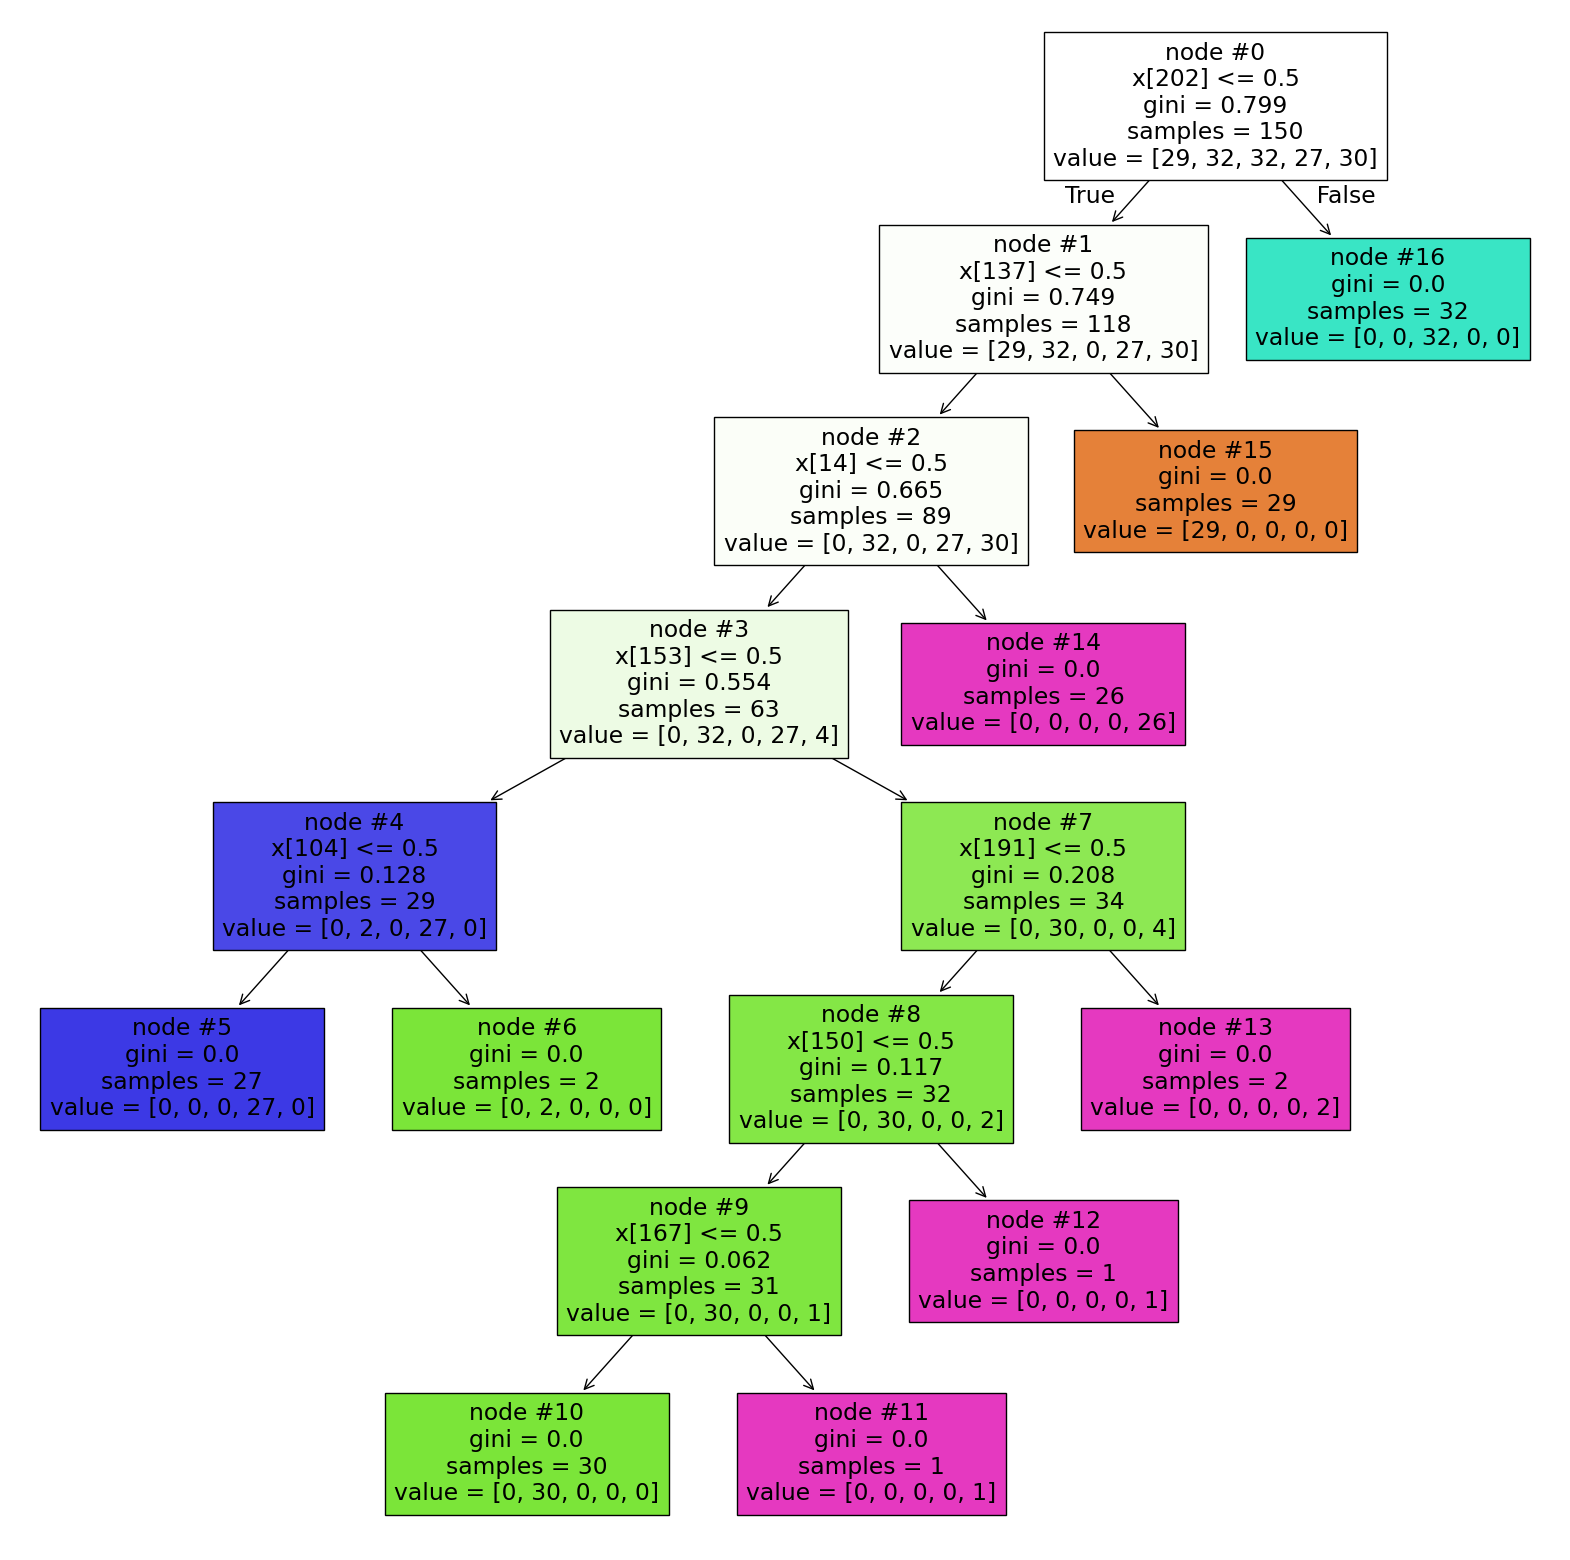

In [143]:
# DecisionTree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X.values, df["CATEGORY"].values)

print(f"Depth: {decision_tree.get_depth()}")
print(f"Leaves: {decision_tree.get_n_leaves()}")

plt.figure(figsize=(20,20))
plot_tree(decision_tree, node_ids=True, filled=True)

## 3. Chatbot based on DecisionTree

In [145]:
# Simulate chatbot (note: user input does not work on Github Jupyter Files)

user_input = ["What is the delivery date?", "What is the weight of the product?", "How do I complaint about the product?", "How will I know that my payment is successfull?"]
print()

question = random.choice(user_input)

prediction = decision_tree.predict(count_vect.transform([question]))[0]
response_options = df.loc[df["CATEGORY"] == prediction, "ANSWERS"].values.tolist()

print(f"Question: {question}")
print("\n")
print(f"Response Category: {prediction}")
print("\n")
print(f"Response: {random.choice(response_options[random.randint(0,4)])}")



Question: How do I complaint about the product?


Response Category: Product Complaints


Response:  Fill out the refund request form on our website.
